In [1]:
from langchain_openai import ChatOpenAI

import config

llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=config.OPENAI_API_KEY
)

In [2]:
from typing import TypedDict, Annotated, List
import operator

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[List, operator.add]

In [3]:
import os
from typing import Dict, List

from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

In [4]:
def search_web(state: State) -> Dict[str, List[str]]:
    """Retrieve docs from web search"""

    os.environ["TAVILY_API_KEY"] = config.TAVILY_API_KEY

    tavily_search = TavilySearchResults(
        max_results=3)
    search_docs = tavily_search.invoke(state["question"])

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f"""<Document href="{doc["url"]}"/>\n{doc["content"]}</Document>"""
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}
    

In [5]:
def search_wikipedia(state: State) -> Dict[str, List[str]]:
    """Retrieve docs from wikipedia search"""

    search_docs = WikipediaLoader(
        query=state["question"],
        load_max_docs=2
    ).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f"""<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}</Document>"""
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [6]:
def generate_answer(state: State) -> Dict[str, str]:
    """Node to answer a question."""

    context = state["context"]
    question = state["question"]

    answer_templat = """Answer the question {question} using the context: {context}"""
    answer_instructions = answer_templat.format(
        question=question,
        context=context
    )

    answer = llm.invoke(
        [
            SystemMessage(content=answer_instructions, name="System"),
            HumanMessage(content=question, name="User")
        ]
    )

    return {"answer": answer.content}

In [7]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

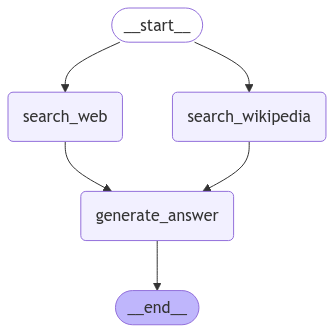

In [8]:
builder = StateGraph(State)

builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
result = graph.invoke({"question": "what are expectations for Nvidia Q1 2025 earnings?"})
print(result)

{'question': 'what are expectations for Nvidia Q1 2025 earnings?', 'answer': "For Nvidia's Q1 2025 earnings, expectations indicate total revenues of approximately $24.7 billion, which has remained stable since Q4 2024. Recent trends show that while there has been some stabilization in analysts' upward revisions for the Data Center segment, guidance for Q2 and FY 2025 will be crucial to observe, especially concerning continued higher pricing and volumes. As of now, the consensus for the Data Center segment for FY 2025 has been revised upward by an additional $4.2 billion to reach $97.7 billion.\n\nHowever, Nvidia's actual reported revenues came in higher than expected at $26.0 billion for the first quarter, marking an 18% increase from the previous quarter and a substantial 262% increase year-over-year. Additionally, the earnings per share (EPS) was reported at $5.98, reflecting a 21% quarter-over-quarter increase and a remarkable 629% increase from the same period last year. Overall, N